## CNN_LSTM Base
- to capture spatial (CNN) -temporal (LSTM) information
- often used in NEXT FRAME VIDEO PREDICTION problem in vision


### Sources

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9063513

https://keras.io/examples/vision/conv_lstm/

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os

%matplotlib inline


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image,preprocess_image
from sklearn.model_selection import train_test_split

In [39]:
# Reading Data
dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)



In [29]:
xco2_images= []

for i in xco2.XCO2.data:
    tmp=(np.repeat(i,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)
xco2_images.shape

(421, 180, 360)

In [53]:
chl_images=preprocess_image(chl.Chl.data)
mld_images=preprocess_image(mld.MLD.data)
sss_images=preprocess_image(sss.SSS.data)
sst_images=preprocess_image(sst.SST.data)
#xco2_images=preprocess_image(xco2_images) # change this cause rn just black, np.rot90
pco2_images=preprocess_image(pco2.pCO2.data,True)

X = np.stack((chl_images, mld_images, sss_images, sst_images,pco2_images), axis = 1)

In [32]:
from functools import partial

INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

Text(0.5, 1.0, 'PCO2')

<Figure size 432x288 with 0 Axes>

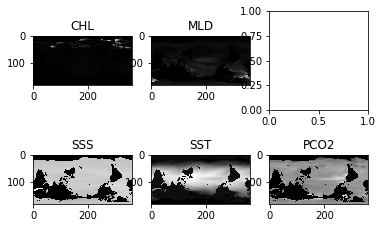

In [44]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,3) 


axarr[0,0].imshow(chl_images[0], cmap="gray", interpolation="nearest")
axarr[0,0].set_title('CHL')
axarr[0,1].imshow(mld_images[0], cmap="gray", interpolation="nearest")
axarr[0,1].set_title('MLD')
axarr[1,0].imshow(sss_images[0], cmap="gray", interpolation="nearest")
axarr[1,0].set_title('SSS')

axarr[1,1].imshow(sst_images[0], cmap="gray", interpolation="nearest")
axarr[1,1].set_title('SST')
#axarr[0,2].imshow(xco2_images[0], cmap="gray", interpolation="nearest")
#axarr[0,2].set_title('XCO2')

axarr[1,2].imshow(pco2_images[0], cmap="gray", interpolation="nearest")
axarr[1,2].set_title('PCO2')


In [54]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


In [55]:
x_train, y_train = create_shifted_frames(X)

In [56]:
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))


Training Dataset Shapes: (421, 4, 180, 360, 1), (421, 4, 180, 360, 1)


Displaying frames for example 61.


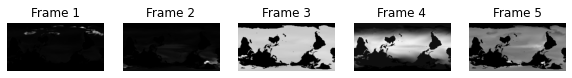

In [61]:
fig, axes = plt.subplots(1, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(X)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(X[data_choice][idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [64]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [65]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 180, 360, 1 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 180, 360, 64 416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 180, 360, 64 256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 180, 360, 64 295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 180, 360, 64 256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 180, 360, 64 33024     
_________________________________________________________________
conv3d (Conv3D)              (None, None, 180, 360, 1) 1729  

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_train, y_train),
    callbacks=[early_stopping, reduce_lr],
)